# Прогнозирование оттока клиентов в сети отелей «Как в гостях»

Заказчик этого исследования — сеть отелей «Как в гостях».
Чтобы привлечь клиентов, эта сеть отелей добавила на свой сайт возможность забронировать номер без предоплаты. Однако если клиент отменял бронирование, то компания терпела убытки. Сотрудники отеля могли, например, закупить продукты к приезду гостя или просто не успеть найти другого клиента.
Чтобы решить эту проблему, нужно разработать систему, которая предсказывает отказ от брони. Если модель покажет, что бронь будет отменена, то клиенту предлагается внести депозит. Размер депозита — 80% от стоимости номера за одни сутки и затрат на разовую уборку. Деньги будут списаны со счёта клиента, если он всё же отменит бронь.

### Шаг 1. Откройте файлы с данными

Импортируем необходимые для работы библиотеки:

<a id='import'></a>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler 
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier 
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import cross_val_score

from sklearn.preprocessing import OrdinalEncoder

Сохраним датасеты в переменные `hotel_train` и `hotel_test`:

In [2]:
hotel_train = pd.read_csv('/datasets/hotel_train.csv')
hotel_test = pd.read_csv('/datasets/hotel_test.csv')

Выведем первые пять строк из таблиц на экран:

In [3]:
hotel_train.head()

,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
0,0,0,7.0,2015,July,27,1,0,1,1.0,...,0,0,0,A,0,0,Transient,0,0,1
1,1,0,14.0,2015,July,27,1,0,2,2.0,...,0,0,0,A,0,0,Transient,0,1,2
2,2,0,0.0,2015,July,27,1,0,2,2.0,...,0,0,0,C,0,0,Transient,0,0,2
3,3,0,9.0,2015,July,27,1,0,2,2.0,...,0,0,0,C,0,0,Transient,0,1,2
4,4,1,85.0,2015,July,27,1,0,3,2.0,...,0,0,0,A,0,0,Transient,0,1,3


In [4]:
hotel_test.head()

,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
0,6086,1,74.0,2017,January,1,1,1,0,2.0,...,0,0,0,A,0,0,Transient,0,0,1
1,6087,1,62.0,2017,January,1,1,2,2,2.0,...,0,0,0,A,0,0,Transient,0,1,4
2,6088,1,62.0,2017,January,1,1,2,2,2.0,...,0,0,0,A,0,0,Transient,0,1,4
3,6089,1,71.0,2017,January,1,1,2,2,1.0,...,0,0,0,A,0,0,Transient,0,1,4
4,6090,1,172.0,2017,January,1,1,2,5,2.0,...,0,0,0,A,0,0,Transient,0,0,7


В таблицах `hotel_train` и `hotel_test` содержатся одинаковые столбцы:
* `id` — номер записи;
* `adults` — количество взрослых постояльцев;
* `arrival_date_year` — год заезда;
* `arrival_date_month` — месяц заезда;
* `arrival_date_week_number` — неделя заезда;
* `arrival_date_day_of_month` — день заезда;
* `babies` — количество младенцев;
* `booking_changes` — количество изменений параметров заказа;
* `children` — количество детей от 3 до 14 лет;
* `country` — гражданство постояльца;
* `customer_type` — тип заказчика:
    * Contract — договор с юридическим лицом;
    * Group — групповой заезд;
    * Transient — не связано с договором или групповым заездом;
    * Transient-party — не связано с договором или групповым заездом, но связано с бронированием типа Transient.
* `days_in_waiting_list` — сколько дней заказ ожидал подтверждения;
* `distribution_channel` — канал дистрибуции заказа;
* `is_canceled` — отмена заказа;
* `is_repeated_guest` — признак того, что гость бронирует номер второй раз;
* `lead_time` — количество дней между датой бронирования и датой прибытия;
* `meal` — опции заказа:

    * SC — нет дополнительных опций;
    * BB — включён завтрак;
    * HB — включён завтрак и обед;
    * FB — включён завтрак, обед и ужин.

* `previous_bookings_not_canceled` — количество подтверждённых заказов у клиента;
* `previous_cancellations` — количество отменённых заказов у клиента;
* `required_car_parking_spaces` — необходимость места для автомобиля;
* `reserved_room_type` — тип забронированной комнаты;
* `stays_in_weekend_nights` — количество ночей в выходные дни;
* `stays_in_week_nights` — количество ночей в будние дни;
* `total_nights` — общее количество ночей;
* `total_of_special_requests` — количество специальных отметок.

### Шаг 2. Предобработка и исследовательский анализ данных

#### Первичное изучение данных

Выведем информацию о таблицах при помощи метода `info`:

In [5]:
hotel_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65229 entries, 0 to 65228
Data columns (total 25 columns):
id                                65229 non-null int64
is_canceled                       65229 non-null int64
lead_time                         65229 non-null float64
arrival_date_year                 65229 non-null int64
arrival_date_month                65229 non-null object
arrival_date_week_number          65229 non-null int64
arrival_date_day_of_month         65229 non-null int64
stays_in_weekend_nights           65229 non-null int64
stays_in_week_nights              65229 non-null int64
adults                            65229 non-null float64
children                          65229 non-null float64
babies                            65229 non-null float64
meal                              65229 non-null object
country                           65229 non-null object
distribution_channel              65229 non-null object
is_repeated_guest                 65229 non-null int64

In [6]:
hotel_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32412 entries, 0 to 32411
Data columns (total 25 columns):
id                                32412 non-null int64
is_canceled                       32412 non-null int64
lead_time                         32412 non-null float64
arrival_date_year                 32412 non-null int64
arrival_date_month                32412 non-null object
arrival_date_week_number          32412 non-null int64
arrival_date_day_of_month         32412 non-null int64
stays_in_weekend_nights           32412 non-null int64
stays_in_week_nights              32412 non-null int64
adults                            32412 non-null float64
children                          32412 non-null float64
babies                            32412 non-null float64
meal                              32412 non-null object
country                           32412 non-null object
distribution_channel              32412 non-null object
is_repeated_guest                 32412 non-null int64

Как видим, таблица `hotel_train` содержит 65229 записей,  `hotel_test` - 32412. Все столбцы таблиц не содержат пропусков.

#### Поиск дубликатов

Проверим таблицы на наличие явных дубликтов:

In [7]:
print(hotel_test.duplicated().sum())
print(hotel_train.duplicated().sum())

0
0


Явных дубликатов в таблицах нет.

Проверим на наличие неявных дубликатов столбцы, содержащие категориальные переменные. Начнем со столбца `meal`. Он должен содержать только 4 значения: SC, BB, HB, FB. Выведем, уникальные значения в таблицах при помощи метода `unique()`:

In [8]:
hotel_train['meal'].unique()

array(['BB       ', 'FB       ', 'HB       ', 'SC       ', 'SC'],
      dtype=object)

In [9]:
hotel_test['meal'].unique()

array(['BB       ', 'HB       ', 'SC', 'FB       ', 'SC       '],
      dtype=object)

Как видим, таблицы содержат неявные дубликаты `'SC       '`, `'SC'`, причина их появления - это лишние пробелы. Избавимся от них при помощи метода `strip`:

In [10]:
hotel_test['meal'] = hotel_test['meal'].str.strip()
hotel_train['meal'] = hotel_train['meal'].str.strip()

Убедимся, что теперь таблицы не содержат неявных дубликатов:

In [11]:
hotel_test['meal'].value_counts()

BB    24684
SC     5293
HB     2399
FB       36
Name: meal, dtype: int64

In [12]:
hotel_train['meal'].value_counts()

BB    51697
HB     7292
SC     5789
FB      451
Name: meal, dtype: int64

Выведем уникальные значения для столбца `'reserved_room_type'` таблиц:

In [13]:
hotel_train['reserved_room_type'].unique()

array(['A               ', 'C               ', 'D               ',
       'E               ', 'G               ', 'F               ',
       'B               '], dtype=object)

In [14]:
hotel_test['reserved_room_type'].unique()

array(['A               ', 'E               ', 'G               ',
       'D               ', 'F               ', 'C               ',
       'B               '], dtype=object)

Наличие лишних пробелов может спровоцировать появление неявных дубликатов, поэтому избавимся от них с помощью метода `strip`:

In [15]:
hotel_test['reserved_room_type'] = hotel_test['reserved_room_type'].str.strip()
hotel_train['reserved_room_type'] = hotel_train['reserved_room_type'].str.strip()

Проверим, что функция сработала корректно:

In [16]:
print(hotel_train['reserved_room_type'].unique())
print(hotel_train['reserved_room_type'].unique())

['A' 'C' 'D' 'E' 'G' 'F' 'B']
['A' 'C' 'D' 'E' 'G' 'F' 'B']


#### Изменение типов данных

Теперь перейдем к приведению к нужным типам. В таблицах есть столбцы в формате float64: 'lead_time', 'adults', 'children', 'babies'. Все они содержат информацию о количестве дней или людей в целых числах. Поэтому будет правильней, если эти столбцы будут в формате int64. Приведем их к требуемому типу:

In [17]:
columns = ['lead_time', 'adults', 'children', 'babies']
tables = [hotel_test, hotel_train]
for table in tables:
    for col in columns:
        table[col] = table[col].astype('int64')
    

#### Работа с выбросами

Далее исследуем таблицы, а именно столбцы, содержащие количественные переменные. Для этого вызовем метод `describe`:

In [18]:
hotel_train.describe()

,id,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,required_car_parking_spaces,total_of_special_requests,total_nights
count,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000
mean,43544.069172,0.368609,96.337917,2015.719021,31.339772,15.847813,0.825185,2.224793,1.836576,0.074890,0.007236,0.027151,0.128915,0.107713,0.194269,3.334422,0.056647,0.512763,3.049978
std,25614.858971,0.482431,96.127545,0.449481,13.464024,8.748182,0.853477,1.354992,0.480245,0.334243,0.098790,0.162523,0.965326,1.326638,0.593838,18.239606,0.232094,0.752590,1.738108
min,0.000000,0.000000,0.000000,2015.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,19108.000000,0.000000,17.000000,2015.000000,21.000000,8.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
50%,40554.000000,0.000000,64.000000,2016.000000,34.000000,16.000000,1.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
75%,67414.000000,1.000000,151.000000,2016.000000,42.000000,23.000000,2.000000,3.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,4.000000
max,84121.000000,1.000000,374.000000,2016.000000,53.000000,31.000000,4.000000,6.000000,4.000000,3.000000,10.000000,1.000000,26.000000,58.000000,17.000000,259.000000,3.000000,5.000000,10.000000


In [19]:
hotel_test.describe()

,id,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,required_car_parking_spaces,total_of_special_requests,total_nights
count,32412.000000,32412.000000,32412.000000,32412.0,32412.000000,32412.000000,32412.000000,32412.00000,32412.000000,32412.000000,32412.000000,32412.000000,32412.000000,32412.000000,32412.000000,32412.000000,32412.000000,32412.000000,32412.000000
mean,60131.505183,0.388467,97.587869,2017.0,17.804054,15.656948,0.867888,2.34009,1.858602,0.083765,0.005523,0.031377,0.011601,0.171418,0.216741,0.262341,0.046248,0.657781,3.207979
std,29953.586177,0.487409,86.507146,0.0,9.177384,8.766429,0.853394,1.37517,0.489341,0.343470,0.075757,0.174338,0.180473,1.875170,0.640551,4.733027,0.219367,0.834341,1.738683
min,6086.000000,0.000000,0.000000,2017.0,1.000000,1.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,45291.750000,0.000000,23.000000,2017.0,10.000000,8.000000,0.000000,1.00000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
50%,53394.500000,0.000000,76.000000,2017.0,18.000000,15.500000,1.000000,2.00000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
75%,89800.250000,1.000000,155.000000,2017.0,25.000000,23.000000,2.000000,3.00000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,4.000000
max,97903.000000,1.000000,373.000000,2017.0,35.000000,31.000000,4.000000,6.00000,4.000000,3.000000,2.000000,1.000000,6.000000,72.000000,18.000000,223.000000,8.000000,5.000000,10.000000


Исходя из таблицы, во многих столбцах таблицы возможны выбросы. 
Начнем со столбца `'lead_time'` — количество дней между датой бронирования и датой прибытия. Как видим, медианное значение - 64 дня, граница третьего квартиля - 151, а максимальное значение - 374. Построим диаграмму размаха, чтобы визуально отобразить, какие значения корректно считать выбросами:

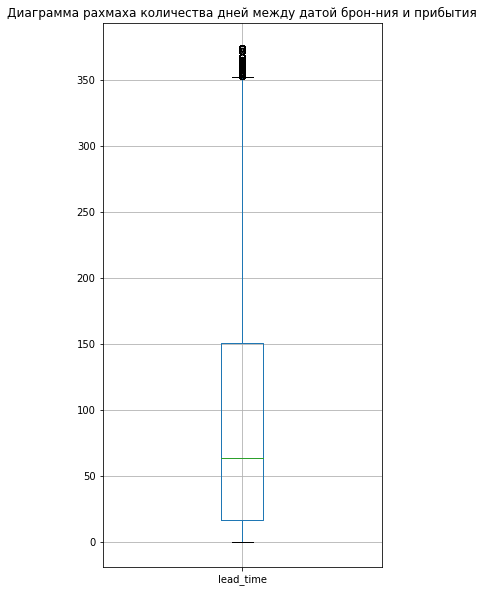

In [20]:
hotel_train['lead_time'].plot(kind='box',figsize=(5,10), grid=True, legend=True, title='Диаграмма рахмаха количества дней между датой брон-ния и прибытия')

Как видим из диаграммы размаха, все значения, которые больше 350 можно считать выбросами. Возможно, они появились из-за технической ошибки, и 350 - это величина не в днях, а в часах (соответсвует 15 дням). Маловероятно, но возможно то, что кто-то почти за год планирует отпуск.
Всего строк, с аномально большим значением в столбце 'lead_time' - 567, что меньше 1% от количества записей в исходном датасете, поэтому удалим их:

In [21]:
hotel_train.query('lead_time>350')['lead_time'].count()

567

In [22]:
hotel_train = hotel_train.query('lead_time<350')

Построим такую же диаграмму размаха для тестовой выборки:

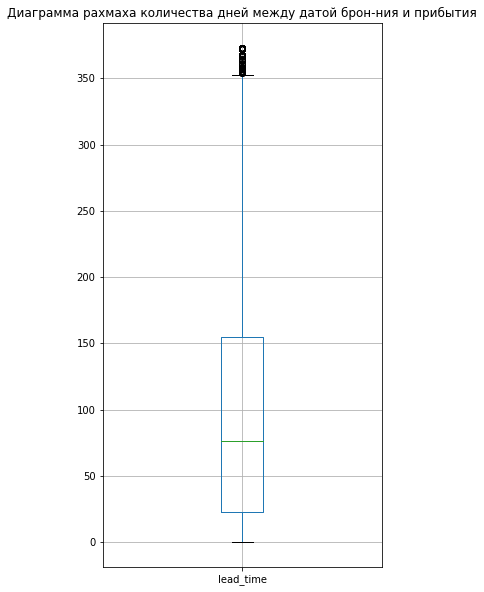

In [23]:
hotel_test['lead_time'].plot(kind='box',figsize=(5,10), grid=True, legend=True, title='Диаграмма рахмаха количества дней между датой брон-ния и прибытия')

Как видим, здесь ситуация похожая: есть значения выше 350, и все они - выбросы. Также как и в обучающей выборке, удалим из тестовой записи, где в столбце 'lead_time' значения большие, чем 350:

In [24]:
hotel_test = hotel_test.query('lead_time<350')

Теперь перейдем к детальному изучению данных в столбце `'adults'`. Исходя из таблицы, у нас есть строки с нулевым числом взрослых постояльцев в обучающей и тестовых выборках, чего быть не может. Причина появления нулевых значений может быть в том, что постояльцы при оформлении бронирования не заполнили поле 'adults' или перепутали с полем 'children' / 'babies', а система пропустила такое значение. В любом случае, такие записи некорректны, поэтому лучше будет удалить их:

In [25]:
hotel_train = hotel_train.query('adults!=0')
hotel_test = hotel_test.query('adults!=0')

Далее перейдем к столбцу `'babies'` - количество младенцев. Из таблицы видно, что в тестовой выборке есть записи со значением 10. Поэтому с помощью метода `value_counts` выведем количество каждого из значений:

In [26]:
hotel_train['babies'].value_counts()

0     63975
1       443
2         3
10        1
9         1
Name: babies, dtype: int64

Значения 9 и 10 в столбце 'babies' - это выбросы. Скорее всего, эти значения либо обозначают пропуск, либо были ошибочно введены (например, поставили 9 вместо 0, так как на клавиатуре они рядом, вручную вставили 1 рядом с 0, когда хотели записать 1). Таких записей крайне мало, поэтому удалим их:

In [27]:
hotel_train = hotel_train.query('babies < 9')

Столбец 'required_car_parking_spaces' описывает `необходимость` места для автомобиля, то есть отвечает на вопрос: надо ли место для автомобиля? (да или нет). С помощью метода `value_counts()` выведем количество записей относительно числа парковочных мест для двух таблиц:

In [28]:
display(hotel_test['required_car_parking_spaces'].value_counts())
display(hotel_train['required_car_parking_spaces'].value_counts())

0    30664
1     1465
2        6
8        2
3        1
Name: required_car_parking_spaces, dtype: int64

0    60754
1     3655
2       11
3        1
Name: required_car_parking_spaces, dtype: int64

Учитывая описание столбцов таблиц, а также количество записей со значением больше 1 в столбце 'required_car_parking_spaces' таблиц, можно заключить, что значения 2,3, 8 - это выбросы и их количество очень мало. Поэтому удалим эти строки:

In [29]:
hotel_train = hotel_train.query('required_car_parking_spaces < 2')
hotel_test = hotel_test.query('required_car_parking_spaces < 2')

Теперь перейдем к столбцу `'booking_changes'` - количество изменений параметров заказа. Из таблиц, выведенных методом `describe` мы видим, что в таблицах hotel_train и  hotel_test максимальное количество изменений - 17 и 18 соответственно. При этом, медианное значение равно нулю в обеих таблицах, ровно как и граница третьего квартиля находится на уровне 0.
Для визуального отображения построим гистограммы частот количества изменений параметров заказа для обеих таблиц:

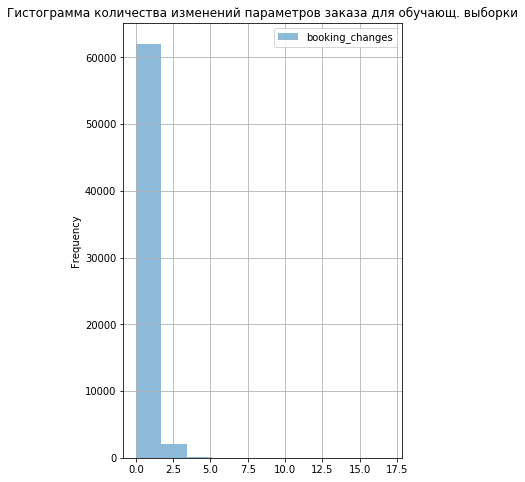

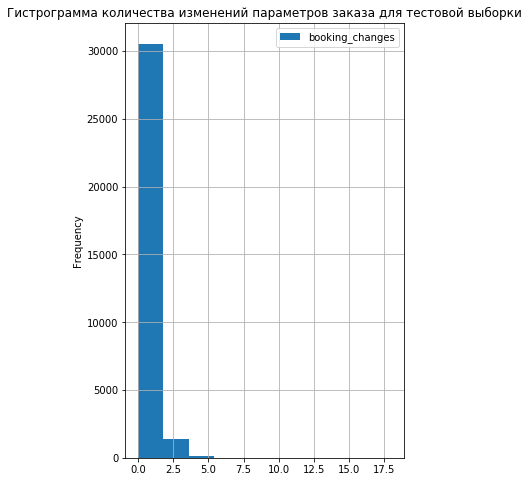

In [30]:
hotel_train['booking_changes'].plot(kind='hist',figsize=(5,8), alpha = 0.5,grid=True, legend=True, title='Гистограмма количества изменений параметров заказа для обучающ. выборки')
plt.show()
hotel_test['booking_changes'].plot(kind='hist',figsize=(5,8), grid=True, legend=True, title='Гистрограмма количества изменений параметров заказа для тестовой выборки')

Исходя из графиков будем считать все значения выше 5 - аномальными, поэтому исключим такие записи из таблиц:

In [31]:
hotel_train = hotel_train.query('booking_changes < 6')
hotel_test = hotel_test.query('booking_changes < 6')

Теперь рассмотрим столбец `'days_in_waiting_list'` - сколько дней заказ ожидал подтверждения. Медианное значение в двух таблицах и граница третьего квартиля равны нулю. При этом максимальные значения в таблицах hotel_train и hotel_test равны 259 и 223 соответственно. Построим гистограмму частот, чтобы визуализировать распределение:

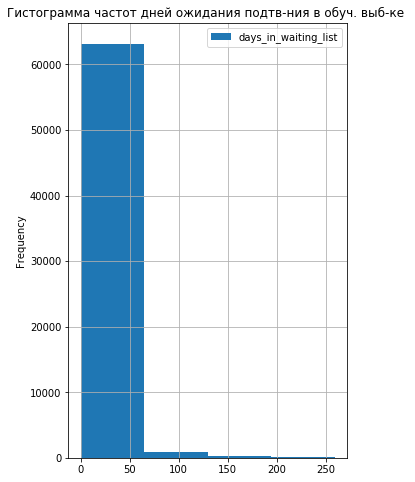

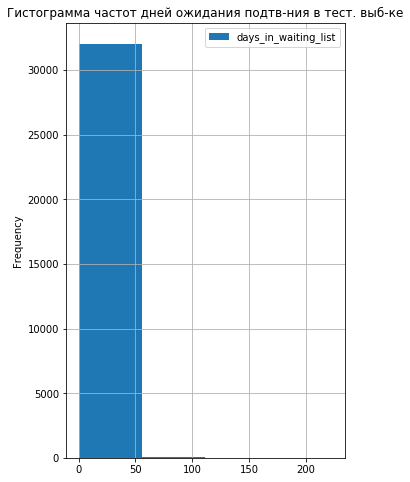

In [32]:
hotel_train['days_in_waiting_list'].plot(kind='hist', bins=4, figsize=(5,8), grid=True, legend=True, title='Гистограмма частот дней ожидания подтв-ния в обуч. выб-ке ')
plt.show()
hotel_test['days_in_waiting_list'].plot(kind='hist', bins=4, figsize=(5,8), grid=True, legend=True, title='Гистограмма частот дней ожидания подтв-ния в тест. выб-ке')


Примем за аномальные значения все строки, где количество дней ожидания подтверждения заказа было свыше 50 дней. Удалим выбросы из таблиц:

In [33]:
hotel_train = hotel_train.query('days_in_waiting_list < 51')
hotel_test = hotel_test.query('days_in_waiting_list < 51')

In [34]:
print(hotel_train.shape[0])
print(hotel_test.shape[0])

62723
32036


Таким образом, сократив выбросы, мы получили 62723 записей в таблице hotel_train (сократилось на 2506) и 32036 в таблице hotel_test (сократилось на 376).

В рамках исследовательского анализа изучим, как признаки взаимосвязаны. Для этого используем матрицу корреляции, а для наглядного представления - используем библиотеку seaborn, которую мы импортировали [ранее](#import):

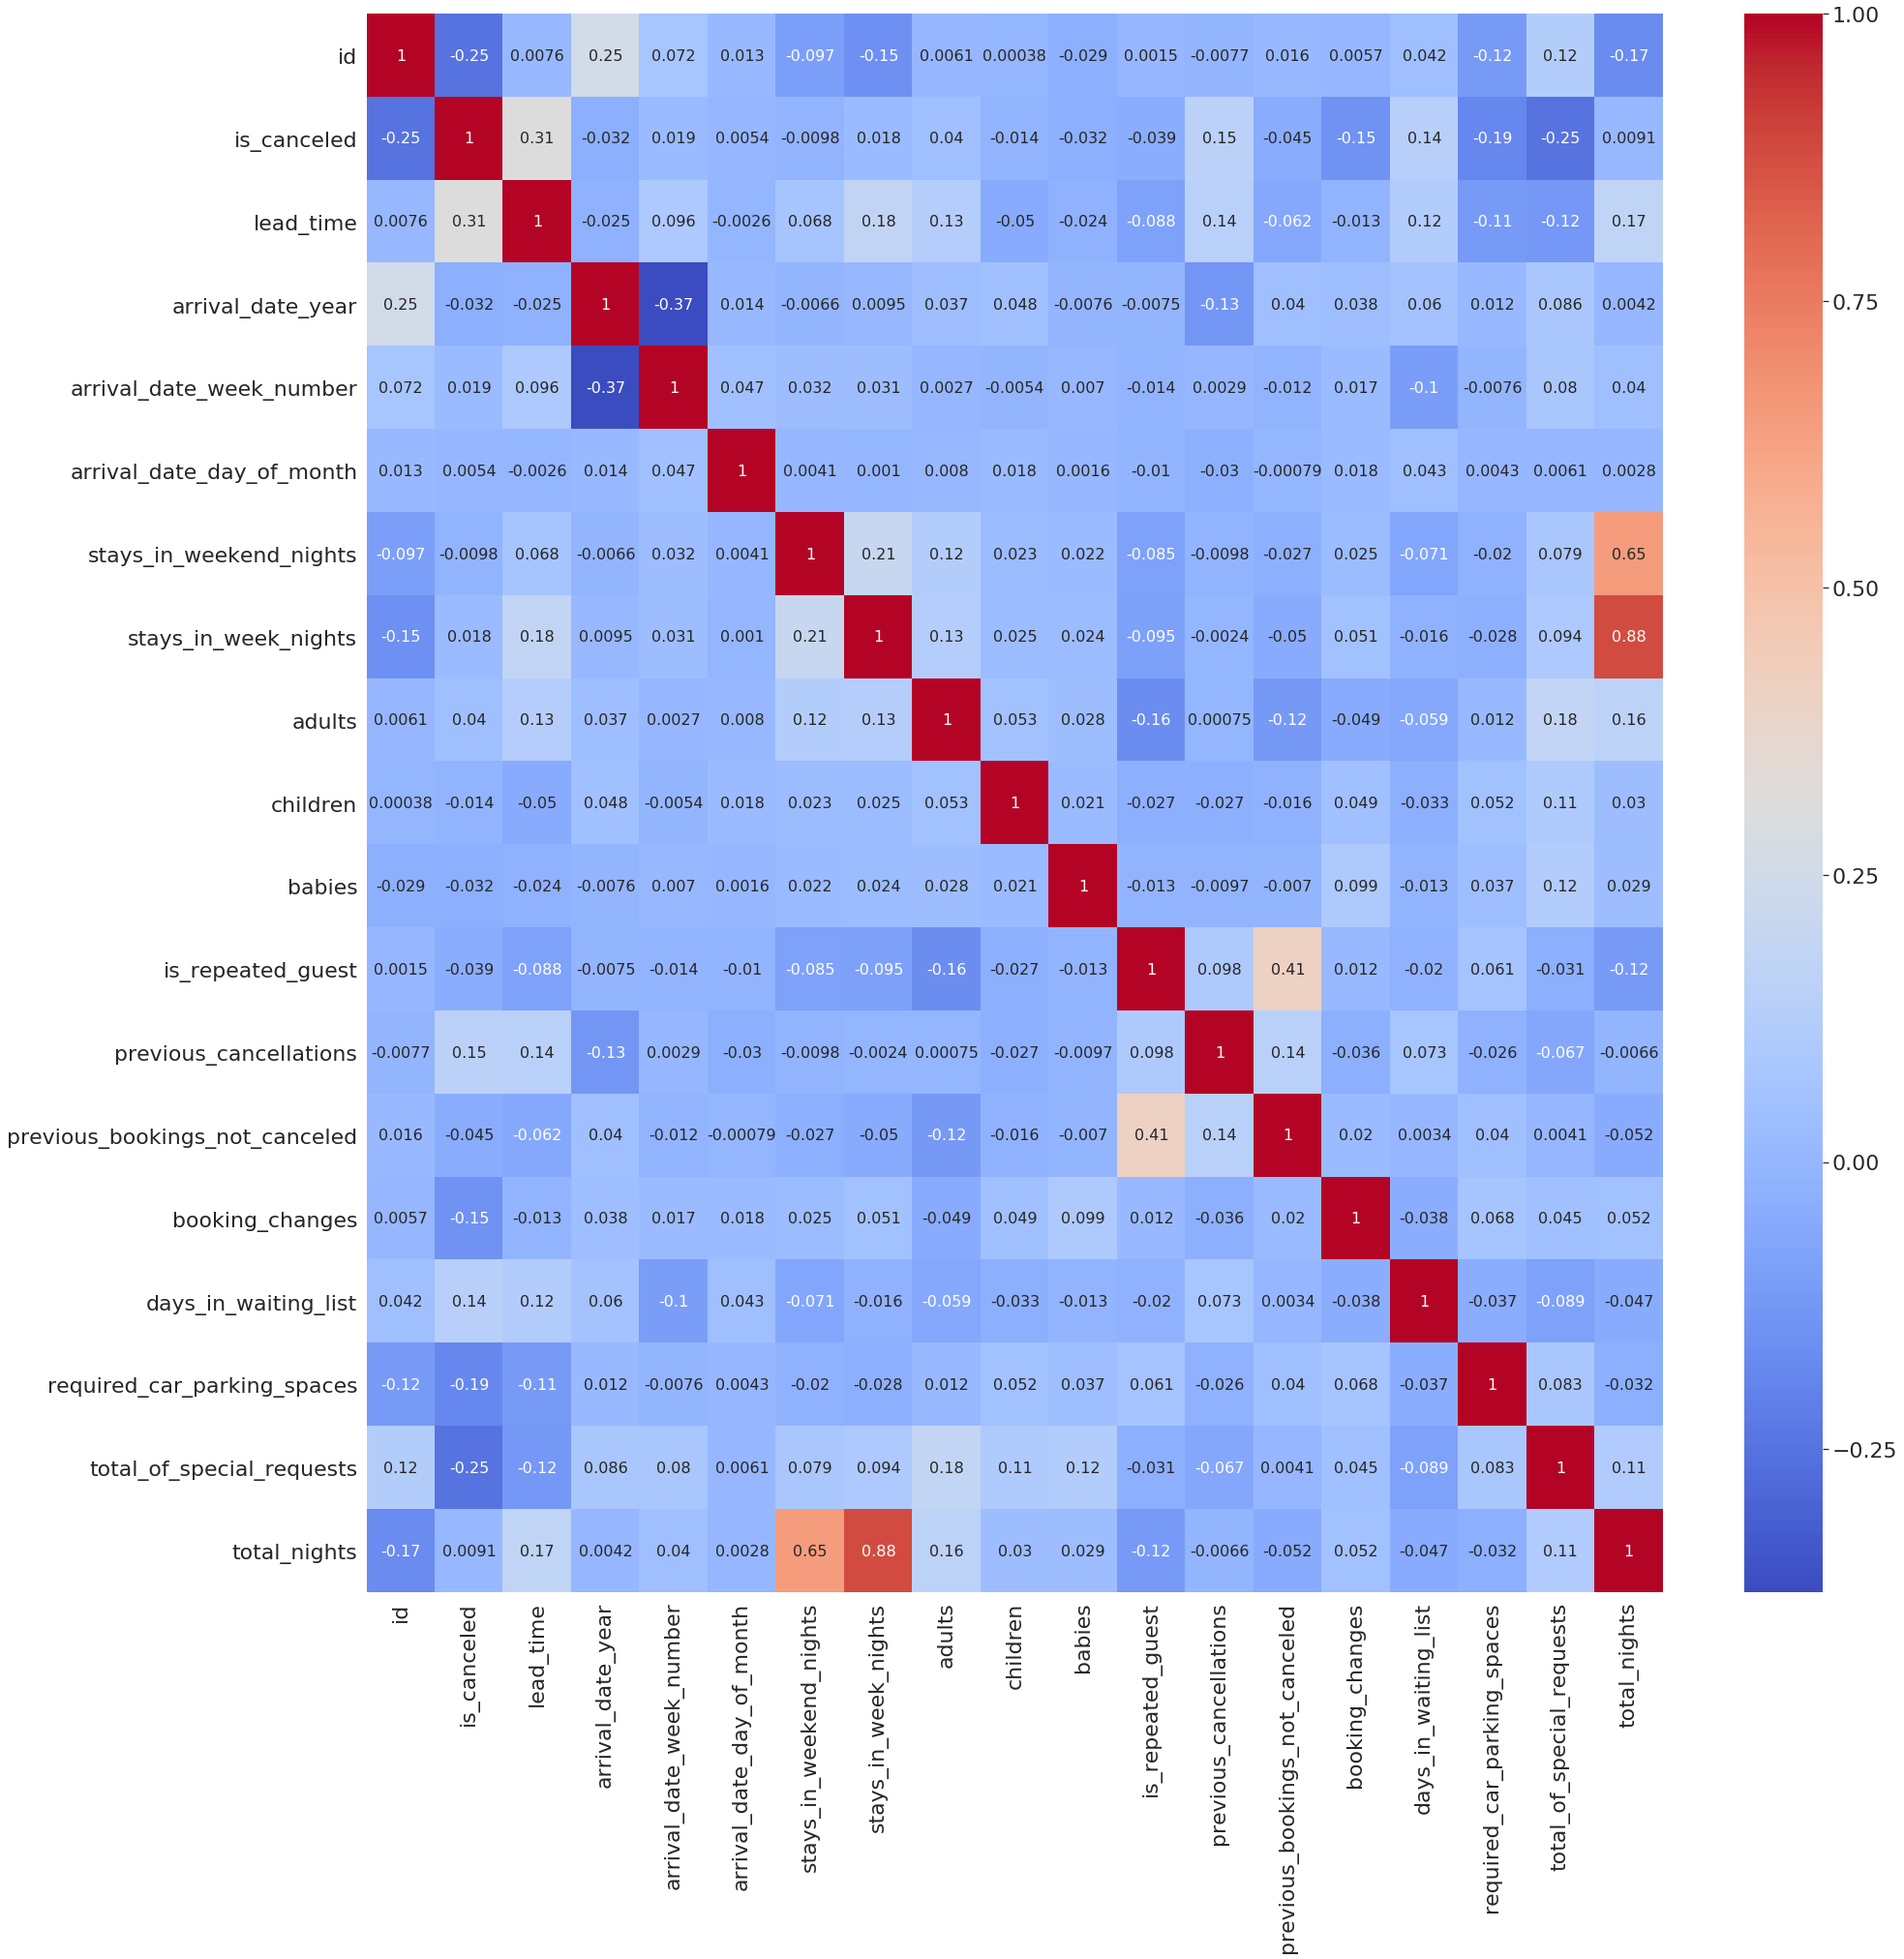

In [35]:
plt.figure(figsize=(30, 30))
sns.set(font_scale=2)
sns.heatmap(hotel_train.corr(), annot = True, fmt='.2g', cmap= 'coolwarm', annot_kws={"fontsize":16})


Ожидаемо наиболее выраженная взаимосвзязь между столбцами `stays_in_weekend_nights` и `total_nights`  - 0.65, а также 
`stays_in_week_nights` и `total_nights` - 0.88. 
Для корректного обучения модели, при ее обучении в дальнейшем нам нужно будет не включать взаимосвязанные признаки.

#### Вывод

В этой части работы мы провели предобработку и исследовательский анализ данных:

* В таблицах не было пропусков и явных дубликатов. 


* В столбце 'meal' избавились от неявных дубликатов. Причина: лишние пропуски. 


* Удалили лишние пропуски в 'reserved_room_type'


* Привели столбцы 'lead_time', 'adults', 'children', 'babies' из float64 к формату int64. 


* Удалили выбросы и аномальные значения из столбцов: 'lead_time' (значения от 350 и выше), 'adults' (равные 0),  'babies' (равные 9 и 10),  'required_car_parking_spaces' (от 2 и выше),  booking_changes (от 6 и выше), 'days_in_waiting_list' ( от 51 и выше).


* Обнаружили взаимосвязь столбца 'total_nights' с 'stays_in_weekend_nights' и 'stays_in_week_nights'


### Шаг 3. Формулировка ML-задачи на основе бизнес-задачи

В описании задания нам даны цены за обслуживание и проживание в комнатах категорий A,B,C,D,F,G,G. 

Создадим таблицу, которая будет содержать в себе тип комнаты, стоимость одной ночи проживания и стоимость разового обслуживания:

In [36]:
columns = ['reserved_room_type' , 'room_price', 'room_prepare']
data = [['A', 1000, 400],['B', 800, 350], ['C', 600, 350], ['D', 550, 150], 
        ['E', 500, 150], ['F', 450, 150], ['G', 350, 150]]
room_data = pd.DataFrame(data=data, columns = columns)

Убедимся, что таблица составлена корректно. Для этого выведем ее на экран:

In [37]:
room_data.head(7)

,reserved_room_type,room_price,room_prepare
0,A,1000,400
1,B,800,350
2,C,600,350
3,D,550,150
4,E,500,150
5,F,450,150
6,G,350,150


Создадим функцию, которая будет подсчитывать прибыль отеля без внедрения депозитов:
<a id='count'></a>

In [38]:
summer = ['June', 'July', 'August']
winter = ['December', 'January', 'February']

def count_revenue(row):
    room_type = row['reserved_room_type']
    month = row['arrival_date_month']
    week_nights = row['stays_in_week_nights']
    weekend_nights = row['stays_in_weekend_nights']
    price = room_data[room_data['reserved_room_type'] == room_type]['room_price'].median()
   
    prepare_cost = room_data[room_data['reserved_room_type'] == room_type]['room_prepare'].median()
    
    total_nights = week_nights + weekend_nights
    if (row['is_canceled'] == 0):
        
        prepare_nights = math.floor((total_nights-1)/2)
        
        if (month in summer):
            revenue = 1.4*price*total_nights - prepare_cost - prepare_nights*prepare_cost

        elif (month in winter):
            revenue = price*total_nights - prepare_cost - prepare_nights*prepare_cost

        else:
            revenue = 1.2 * price*total_nights - prepare_cost - prepare_nights*prepare_cost
    else:
        revenue = - prepare_cost
    return revenue
    

Подсчитаем прибыль отеля без внедрения депозитов на тестовой выборке:

In [39]:
total_revenue = hotel_test.apply(count_revenue, axis=1).sum()
print(total_revenue)

48581530.0


#### Вывод
Таким образом, прибыль отеля составила 48,58 млн.

### Шаг 4. Разработка модели ML

Для того, чтобы обучать модели нам надо выделить признаки и целевой признак. Мы формулируем задачу для модели как задачу классификации: определить будет ли отменена бронь или нет. Поэтому целевой признак - это колонка `'is_canceled'`.

В качестве признаков будем использовать следующие столбцы, которые на наш взгляд могут повлиять на принятие решения об отмене брони: 
`'adults', 'arrival_date_week_number', 'babies', 'country', 'children','customer_type','days_in_waiting_list','is_repeated_guest', 'lead_time', 'meal', 'previous_bookings_not_canceled','previous_cancellations', 'required_car_parking_spaces', 'reserved_room_type', 'stays_in_weekend_nights','stays_in_week_nights', 'total_of_special_requests', 'is_canceled'`.

Создадим переменные hotel_train_ohe и hotel_test_ohe, чтобы в дальнейшем преобразовать категориальные признаки в количественные при помощи OneHotEncoder.

In [40]:
columns_features = ['adults', 'arrival_date_week_number', 'babies', 'children', 'customer_type', 'country',
                    'days_in_waiting_list', 'is_repeated_guest', 'lead_time', 'meal', 'previous_bookings_not_canceled',
                   'previous_cancellations', 'required_car_parking_spaces', 'reserved_room_type', 'stays_in_weekend_nights',
                   'stays_in_week_nights', 'total_of_special_requests', 'is_canceled' ]
hotel_train_ohe = hotel_train[columns_features]
hotel_test_ohe = hotel_test[columns_features]


In [41]:
target_train = hotel_train_ohe['is_canceled']
target_test = hotel_test_ohe['is_canceled']
features_train = hotel_train_ohe.drop('is_canceled', axis=1)
features_test = hotel_test_ohe.drop('is_canceled', axis=1)

Поясним, почему не нужны остальные признаки. 
* id (номер записи) - не несет никакой важной информации, так как это просто способ упорядочить записи
* arrival_date_year (год заезда) - не понадобится, так как в выборке прошедшие года, а модель предсказывает отмену в текущем
* arrival_date_month — месяц заезда. Не включили, так как у нас есть номер недели, что уже включает информацию о месяце
* arrival_date_day_of_month — день заезда. Сам по себе не информативен.
* distribution_channel — канал дистрибуции заказа - этот признак важен, например, при прогнозировании рекламного бюджета, а когда клиент уже сделал бронирование, отмена не зависит от того, откуда клиент "пришел"
* total_nights — общее количество ночей. Взаимозависим со столбцами 'stays_in_weekend_nights','stays_in_week_nights', поэтому не включаем.

В таблице практически все столбцы, кроме customer_type и meal - количественные. Нам нужно построить модель, которая будет решать задачу классификации (отменит клиент бронь или нет). Применим технику OneHotEncoder, чтобы преобразовать категориальные переменные в количественные.

[Ранее](#import) мы импортировали OneHotEncoder из библиотеки sklearn.preprocessing. Создадим объект этой структуры данных:

In [42]:
enc = OneHotEncoder(handle_unknown='ignore')

Преобразуем обучающие и тестовые выборки функцией transform():

In [43]:
enc.fit(features_train)
features_train = enc.transform(features_train) 
features_test = enc.transform(features_test)

Далее обучим модели и оценим их качество кросс-валидацией. Для решения задачи классификации подойдут 3 модели: логистическая регрессия, решающее дерево и случайный лес. Начнем с логистической регрессии:

In [44]:
model = LogisticRegression(random_state=12345, solver='liblinear', class_weight='balanced')
scores = cross_val_score(model,features_train, target_train, cv=5, scoring='f1')
final_score = sum(scores)/len(scores)
print('Средняя оценка качества модели:', final_score)

Средняя оценка качества модели: 0.5240393661969432


Как видим, оценка качества модели логистической регрессии - 0.524.

Теперь перейдем к модели решающего дерева. В цикле переберем гиперпараметры (размер глубины), и выведем на экран при какой глубине результат кросс-валидации дал наивысшую оценку качества модели:

In [45]:
col = ['max_depth', 'final_score']
data = []

for depth in range(1, 15):
    model = DecisionTreeClassifier(random_state=12345, max_depth=depth, class_weight='balanced')
    scores = cross_val_score(model,features_train, target_train, cv=5 , scoring='f1')
    final_score = sum(scores)/len(scores)
    data.append([depth, final_score])
table = pd.DataFrame(data = data, columns=col)
display(table[table['final_score']==table['final_score'].max()]) 

,max_depth,final_score
4,5,0.650274


Получается, при max_depth=5 оценка качества модели кросс-валидацией достигает максимума в 0.65, что уже выше, чем в модели логистической регрессии.

Теперь перейдем к модели случайного леса. Для этого из модуля sklearn.ensemble мы [импортировали](#import) алгоритм случайного леса RandomForestClassifier.

Аналогично работе с предыдущей моделью, в цикле переберем значения гиперпараметра n_estimators, который отвечает за количество деревьев в лесу. Выведем на экран значение  n_estimators при котором возможно получить максимальную оценку качества модели, полученную кросс-валидацией:

In [46]:
col = ['n_estimators', 'final_score']
data = []

for est in range(1, 25):
    model = RandomForestClassifier(random_state=12345, n_estimators=est, class_weight='balanced') 
    scores = cross_val_score(model,features_train, target_train, cv=5, scoring='f1')
    final_score = sum(scores)/len(scores)
    data.append([est, final_score])
table = pd.DataFrame(data = data, columns=col)
display(table[table['final_score']==table['final_score'].max()]) 


,n_estimators,final_score
4,5,0.452555


Как видим, наибольшая оценка достигается при n_estimators=5 и равна 0.452.

Таким образом, лучшая модель - `решающее дерево при max_depth=5`. Теперь проверим ее на тестовой выборке. В качестве метрики оценки качества будем использовать F1-меру и метрику AUC-ROC. 
F1-мера - это агрегирующая метрика, среднее гармоническое полноты и точности. Метрика AUC-ROC показывает, как сильно наша модель отличается от случайной, так как AUC-ROC случайной модели равна 0.5.

'Значение F1-меры на тестовой выборке:'

0.633886436291673

'Значение метрики AUC-ROC:'

0.7747977285779039

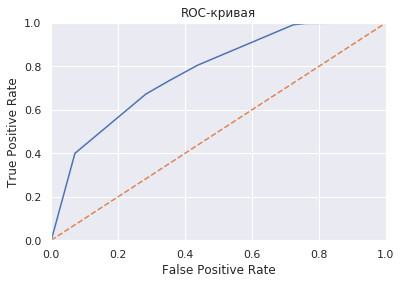

In [47]:
model =  DecisionTreeClassifier(random_state=12345, max_depth=5, class_weight='balanced')
model.fit(features_train, target_train)


predicted_test = model.predict(features_test)
probabilities_test = model.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]
test_f1_score = f1_score(target_test, predicted_test )
auc_roc = roc_auc_score(target_test, probabilities_one_test)

display('Значение F1-меры на тестовой выборке:', test_f1_score) 
display('Значение метрики AUC-ROC:', auc_roc)

sns.set(font_scale=1)
fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test)

plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

Таким образом, модель решающего дерева при величине гиперпараметра max_depth=5 и величине порога = 0.3 показывает на тестовой выборке следующие результаты: 
* F1-мера - 0.634
* Метрика AUC-ROC - 0.775

Теперь проверим на адекватность, выбранную нами модель. Для этого посмотрим, как справится с задачей фиктивный классификатор DummyClassifier ([импортировали ранее](#import)). Он покажет вероятность успеха, даже если просто "угадать". Таким образом, чтобы признать модель адекватной, нужно, чтобы показатели метрик были выше, чем те, которые получатся у фиктивного классификатора. Так как от значения параметра strategy может поменяться результат, переберем их, и для сравнения будем учитывать лучший результат:

In [59]:
names = ['stratified', 'most_frequent', 'prior', 'uniform']
data = []
col = ['name',  'f1_score_test', 'auc_roc_test']
for name in names:
    new_dummy_classifier = DummyClassifier(strategy=name)
    new_dummy_classifier.fit(features_train, target_train)
    test_predictions = new_dummy_classifier.predict(features_test)
    probabilities_test = new_dummy_classifier.predict_proba(features_test)
    probabilities_one_test = probabilities_test[:, 1]
    test_accuracy = accuracy_score(target_test, test_predictions)
    test_f1_score = f1_score(target_test, test_predictions )
    auc_roc_test = roc_auc_score(target_test, probabilities_one_test)
    data.append([name, test_f1_score, auc_roc_test])
table = pd.DataFrame(data = data, columns=col)
display(table[table['f1_score_test']==table['f1_score_test'].max()]) 

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


,name,f1_score_test,auc_roc_test
3,uniform,0.434403,0.5


Как видим, показатели у лучшего (при значении параметра strategy='uniform') из фиктивных классификаторов намного ниже, чем у нашей модели, и находятся на уровне 0.43 для F1-меры, а также 0.5- для метрики AUC-ROC.

Таким образом можно заключить, что наша модель прошла тест на адекватность.

Теперь оценим прибыль, которую модель принесет за год.

In [49]:
model =  DecisionTreeClassifier(random_state=12345, max_depth=5, class_weight='balanced')
model.fit(features_train, target_train)
predicted_test = model.predict(features_test)

Сохраним предсказания модели в таблице hotel_test:

In [50]:
hotel_test['predictions'] = predicted_test
display(hotel_test.head())

,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights,predictions
0,6086,1,74,2017,January,1,1,1,0,2,...,0,0,A,0,0,Transient,0,0,1,1
1,6087,1,62,2017,January,1,1,2,2,2,...,0,0,A,0,0,Transient,0,1,4,0
2,6088,1,62,2017,January,1,1,2,2,2,...,0,0,A,0,0,Transient,0,1,4,0
3,6089,1,71,2017,January,1,1,2,2,1,...,0,0,A,0,0,Transient,0,1,4,0
4,6090,1,172,2017,January,1,1,2,5,2,...,0,0,A,0,0,Transient,0,0,7,1


Теперь на основе функции [count_revenue](#count) создадим функцию, которая подсчитает прибыль отеля с учетом введения депозитов:

In [51]:
summer = ['June', 'July', 'August']
winter = ['December', 'January', 'February']

def count_revenue_with_deposit(row):
    room_type = row['reserved_room_type']
    month = row['arrival_date_month']
    week_nights = row['stays_in_week_nights']
    weekend_nights = row['stays_in_weekend_nights']
    price = room_data[room_data['reserved_room_type'] == room_type]['room_price'].median()
    prepare_cost = room_data[room_data['reserved_room_type'] == room_type]['room_prepare'].median()
    total_nights = week_nights + weekend_nights
    if (row['predictions']==1):
        deposit = 0.8*price
    else:
        deposit = 0
    
    
    if (row['is_canceled'] == 0):
        
        prepare_nights = math.floor((total_nights-1)/2)
        

        if (month in summer):
            revenue = 1.4*price*total_nights - prepare_cost - prepare_nights*prepare_cost

        elif (month in winter):
            revenue = price*total_nights - prepare_cost - prepare_nights*prepare_cost

        else:
            revenue = 1.2 * price*total_nights - prepare_cost - prepare_nights*prepare_cost
    else:
        revenue = deposit - prepare_cost
    return revenue
    

In [52]:
total_revenue_deposit = hotel_test.apply(count_revenue_with_deposit, axis=1).sum()
print(total_revenue_deposit)

54576610.0


Теперь подсчитаем чистую прибыль отеля после введения системы депозитов с учетом стоимости разработки системы прогнозирования:

In [53]:
IMPLEMENTATION_COST = 400000
net_profit = total_revenue_deposit  - total_revenue - IMPLEMENTATION_COST
print(net_profit)

5595080.0


Таким образом, с учетом стоимости введения системы депозитов, отель за год получит дополнительно 5.595 млн. чистой прибыли

#### Вывод
* Отель до внедрения системы депозитов за 2017 год получил прибыль  48.58 млн.
* Лучшая модель - решающее дерево при величине гиперпараметра max_depth=5
* Метрики качества на тестовой выборке следующие результаты: F1-мера - 0.634, метрика AUC-ROC - 0.775
* Чистая прибыль после введения депозитов в 2017 году могла стать 54.576 млн
* C учетом стоимости введения системы депозитов, отель за год может получить дополнительно 5.595 млн. чистой прибыли

### Шаг 5. Опишите портрет «ненадёжного» клиента

Проанализируем бронирования, которые модель посчитала отмененными и те, которые действительно ими оказались. Вызовем метод `describe`, чтобы сразу увидеть медианное значение и квартили:

In [54]:
hotel_test.query('is_canceled==1 and predictions==True').describe()

,id,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,required_car_parking_spaces,total_of_special_requests,total_nights,predictions
count,8328.000000,8328.0,8328.000000,8328.0,8328.000000,8328.000000,8328.000000,8328.000000,8328.000000,8328.000000,8328.000000,8328.000000,8328.000000,8328.000000,8328.000000,8328.000000,8328.0,8328.0,8328.000000,8328.0
mean,43994.287224,1.0,118.785543,2017.0,17.613473,15.656460,0.837536,2.350024,1.878602,0.074087,0.000961,0.001921,0.002161,0.006484,0.073967,0.202209,0.0,0.0,3.187560,1.0
std,15104.615915,0.0,78.165201,0.0,8.405157,8.671792,0.854012,1.272082,0.467545,0.334065,0.030981,0.043792,0.069275,0.302833,0.364847,2.513169,0.0,0.0,1.557552,0.0
min,6086.000000,1.0,0.000000,2017.0,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,1.000000,1.0
25%,46178.250000,1.0,56.000000,2017.0,11.000000,8.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,2.000000,1.0
50%,49065.000000,1.0,109.000000,2017.0,18.000000,15.000000,1.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,3.000000,1.0
75%,51924.250000,1.0,169.000000,2017.0,24.000000,23.000000,2.000000,3.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,4.000000,1.0
max,91576.000000,1.0,349.000000,2017.0,35.000000,31.000000,4.000000,6.000000,4.000000,3.000000,1.000000,1.000000,4.000000,26.000000,5.000000,50.000000,0.0,0.0,10.000000,1.0


На основе медиан и значений квартилей можно сказать, что "ненадежный" клиент:
* бронирует номер заранее, в основном - за 106 дней
* бронирует в основном номер на 3 ночи: 1 приходится на выходные, 2 - на будние
* это двое взрослых без детей и младенцев
* никогда не был клиентом отеля, не отменял и не заказывал номера ранее
* не указывает специальные отметки, не вносит правки в бронь
* не запрашивает парковочное место

Проанализируем столбцы, содержащие категориальные переменные:

In [55]:
hotel_test.query('is_canceled==1 and predictions==True')['customer_type'].value_counts(normalize=True)

Transient          0.916427
Transient-Party    0.078770
Contract           0.004083
Group              0.000720
Name: customer_type, dtype: float64

В 94% случаев тип ненадежного клиента не связан с с договором или групповым заездом.

In [56]:
hotel_test.query('is_canceled==1 and predictions==True')['meal'].value_counts(normalize=True)

BB    0.826369
SC    0.120917
HB    0.051153
FB    0.001561
Name: meal, dtype: float64

В 77% случаев выбирают только завтраки, в 94% - завтраки или ничего.

In [57]:
hotel_test.query('is_canceled==1 and predictions==True')['reserved_room_type'].value_counts(normalize=True)

A    0.786383
D    0.148775
E    0.036143
F    0.012488
G    0.008886
C    0.005163
B    0.002161
Name: reserved_room_type, dtype: float64

В 3 из 4 бронирований ненадежные клиенты предпочитают номера типа А.

In [58]:
hotel_test.query('is_canceled==1 and predictions==True')['distribution_channel'].value_counts(normalize=True)

TA/TO        0.903338
Direct       0.051153
Corporate    0.044188
GDS          0.001321
Name: distribution_channel, dtype: float64

В 92% случаев, канал дистрибуции был - TA/TO .

#### Вывод
Портрет ненадежного клиента выглядит следующим образом:
* бронирует номер заранее, в основном - за 106 дней
* бронирует в основном номер на 3 ночи: 1 приходится на выходные, 2 - на будние
* это двое взрослых без детей и младенцев
* никогда не был клиентом отеля, не отменял и не заказывал номера ранее
* не указывает специальные отметки, не вносит правки в бронь
* не запрашивает парковочное место
* не связан с договором или групповым заездом
* вместе с номером выбирает включенный в стоимость завтрак или ничего
* выбирает самый дорогую по стоимости категорию номера (А)
* канал дистрибуции - TA/TO


### Шаг 6. Напишите общий вывод

Лучшая модель - решающее дерево при величине гиперпараметра max_depth=5 и величине порога = 0.3
Её метрики качества на тестовой выборке: F1-мера - 0.636, метрика AUC-ROC - 0.753.

Благодаря внедрению системы депозитов и работе модели можно было увеличить чистую прибыль в 2017 году на 7.537 млн. (и это с учетом стоимости разработки модели).

**Бизнесу можно рекомендовать:**

`1) ввести систему депозитов`

`2) использовать модель для предсказания отказа от брони`

`3) вне зависимости от работы модели ввести обязательный депозит для клиентов, которые бронируют номера больше, чем за 3 месяца.`
